# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import os
import itertools
import pandas as pd

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
import json
with open('rocketman/settings.json') as fp:
    settings = json.load(fp)
temperature_c_options = list(sorted(set(np.array(settings)[:,0])))
L_D_options= list(sorted(set(np.array(settings)[:,1])))
injection_speed_options= list(sorted(set(np.array(settings)[:,2])))
        

In [4]:
temperature_c_options, L_D_options, injection_speed_options

([150.0, 200.0, 250.0],
 [0.430448223, 0.870942813, 1.300618238, 1.728748068],
 [0.2, 0.3, 0.4])

In [5]:
f'1e{np.log10(100):g}', f'{1000:.0e}'

('1e2', '1e+03')

In [6]:

print("Processing SLURM array job.")

rocket_array_dir = 'rocketman'

cti_file = os.path.join(rocket_array_dir,'0','chem_annotated.cti')

print(f"Using cantera input file {os.path.abspath(cti_file)}")

print(f"Settings array is from 0 to {len(settings)-1} ")

from collections import defaultdict
setting_dict = dict()
for i,(temp,ld,speed) in enumerate(settings):
    setting_dict[(temp,ld,speed)] = i


Processing SLURM array job.
Using cantera input file /home/nadeau.ma/Code/HAN/CanteraModels/rocketman/0/chem_annotated.cti
Settings array is from 0 to 35 


In [7]:
data_dict = dict()
for i,(temp,ld,speed) in enumerate(settings):
    output_filename = os.path.join('rocketman',str(i),'surf_pfr_output_'+str(i)+'.csv')
    print(f"{i:3d} {temp:.0f}C L/D: {ld:.2f} injection speed: {speed:.2f}", end=' ')
    try:
        data = pd.read_csv(output_filename)
        print(f"✅ OK  {data['Distance (mm)'].max():5.2f} mm    {data['T (C)'].min():.0f}-{data['T (C)'].max():.0f} ºC")
    except:
        print("❌ FAIL!")
        data = None
    data_dict[(temp,ld,speed)] = data

  0 150C L/D: 0.43 injection speed: 0.20 ✅ OK   7.75 mm    260-2241 ºC
  1 150C L/D: 0.43 injection speed: 0.30 ✅ OK   0.00 mm    171-171 ºC
  2 150C L/D: 0.43 injection speed: 0.40 ✅ OK   0.00 mm    -76--76 ºC
  3 150C L/D: 0.87 injection speed: 0.20 ✅ OK   0.00 mm    -76--76 ºC
  4 150C L/D: 0.87 injection speed: 0.30 ❌ FAIL!
  5 150C L/D: 0.87 injection speed: 0.40 ✅ OK  15.68 mm    260-2116 ºC
  6 150C L/D: 1.30 injection speed: 0.20 ❌ FAIL!
  7 150C L/D: 1.30 injection speed: 0.30 ✅ OK  23.41 mm    171-2382 ºC
  8 150C L/D: 1.30 injection speed: 0.40 ✅ OK  21.12 mm    170-2259 ºC
  9 150C L/D: 1.73 injection speed: 0.20 ✅ OK  31.12 mm    169-2439 ºC
 10 150C L/D: 1.73 injection speed: 0.30 ✅ OK   0.03 mm    -113--79 ºC
 11 150C L/D: 1.73 injection speed: 0.40 ✅ OK  24.05 mm    258-2290 ºC
 12 200C L/D: 0.43 injection speed: 0.20 ✅ OK   0.14 mm    313-1435 ºC
 13 200C L/D: 0.43 injection speed: 0.30 ✅ OK   0.04 mm    321-321 ºC
 14 200C L/D: 0.43 injection speed: 0.40 ✅ OK   0.00 m

In [8]:
def final_comps(temperature_c, ld, speed):

    setting_tuple = (temperature_c, ld, speed)
#     print(f"Simulation number {setting_dict[setting_tuple]}")
    data = data_dict[setting_tuple]

    species_to_plot = ['NO2(9)',
 'NO(10)',
 'H2(13)',
 'O2(8)',
 'N2(7)',
 'CH4(15)',
 'CO(14)', 
 'CO2(12)',                      
 'N2O(11)',
        ]
    
    mol_fracs = data[species_to_plot].tail(1)
     
    return mol_fracs

In [9]:
def plot_at_T_speed(t,speed):
    no2 = []
    no = []
    h2 = []
    o2 = []
    n2 = []
    ch4 = []
    co = []
    co2 = []
    n2o = []

    fracs = []
    
    for ld in L_D_options:
        #create arrays of final mol%s at each L/D option
        try: 
            df = final_comps(t,ld,speed)
            fracs.append(df)
            no2.append(df['NO2(9)'].values[0]*100) #percent
            no.append(df['NO(10)'].values[0]*100) #percent
            h2.append(df['H2(13)'].values[0]*100) #percent
            o2.append(df['O2(8)'].values[0]*100) #percent
            n2.append(df['N2(7)'].values[0]*100) #percent
            ch4.append(df['CH4(15)'].values[0]*100) #percent
            co.append(df['CO(14)'].values[0]*100) #percent
            co2.append(df['CO2(12)'].values[0]*100) #percent
            n2o.append(df['N2O(11)'].values[0]*100) #percent
            
        except TypeError:
            print('no data for {:}C, L/D: {:.2f}, {:.1f}g/s'.format(t,ld,speed))
            no2.append(0)
            no.append(0)
            h2.append(0)
            o2.append(0)
            n2.append(0)
            ch4.append(0)
            co.append(0)
            co2.append(0)
            n2o.append(0)

    no2_no = np.array(no2) + np.array(no)    
    plt.plot(L_D_options,no2_no,'D', label = '$NO_2+NO$')
    plt.plot(L_D_options,h2,'s', label = '$H_2$')
    plt.plot(L_D_options,o2,'x', label = '$O_2$')
    plt.plot(L_D_options,n2,'^',markerfacecolor='none', label = '$N_2$')
    plt.plot(L_D_options,ch4,'*', label = '$CH_4$')
    plt.plot(L_D_options,co,'o', label = '$CO$')
    plt.plot(L_D_options,co2,'o',markerfacecolor='none', label = '$CO_2$')
    plt.plot(L_D_options,n2o,'^', label = '$N_2O$')
    plt.yscale("log")
    plt.xlim(0, 2)
    plt.ylim(0.1,100)
    plt.xticks(ticks=[0,.5,1,1.5,2])
    plt.yticks(ticks=[0.1,1,10,100])
    plt.title('{:}C, {:.1f}g/s'.format(t,speed))
    plt.legend(loc=(1.02,0))
    plt.xlabel('L/D')
    plt.ylabel('vol%')
    plt.grid()
    filename = 'report-graphs_{:}C_p{:}_g_s'.format(int(t),int(speed*10))
    plt.savefig(filename,dpi=200,bbox_inches = "tight")
    plt.show()

no data for 150.0C, L/D: 1.30, 0.2g/s


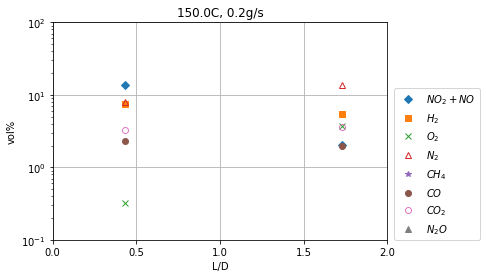

no data for 150.0C, L/D: 0.87, 0.3g/s


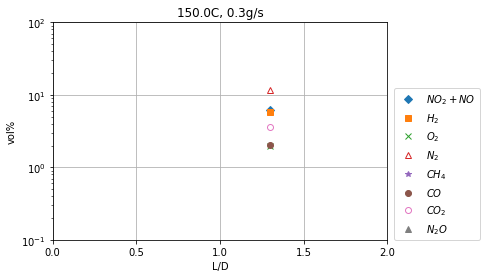

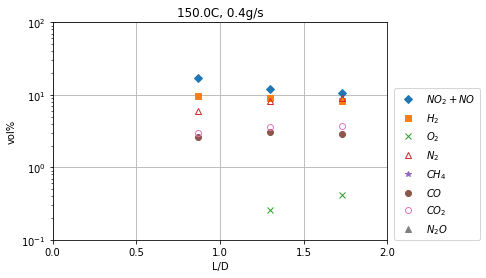

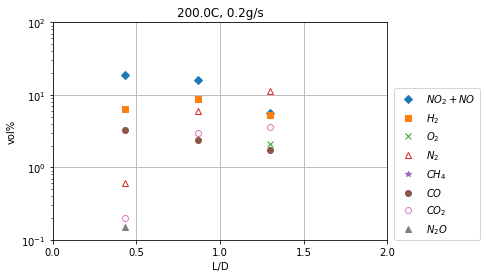

no data for 200.0C, L/D: 0.87, 0.3g/s


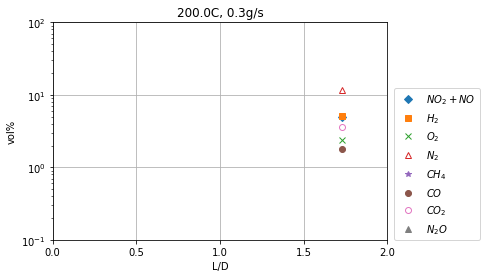

no data for 200.0C, L/D: 0.87, 0.4g/s
no data for 200.0C, L/D: 1.30, 0.4g/s


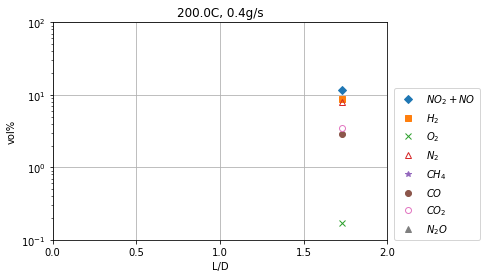

no data for 250.0C, L/D: 1.73, 0.2g/s


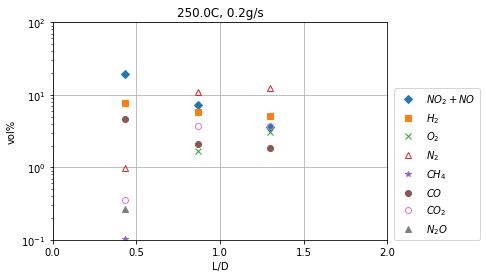

no data for 250.0C, L/D: 0.43, 0.3g/s


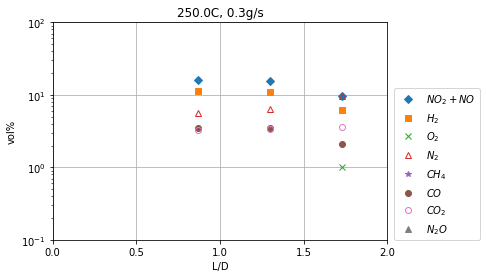

no data for 250.0C, L/D: 0.87, 0.4g/s


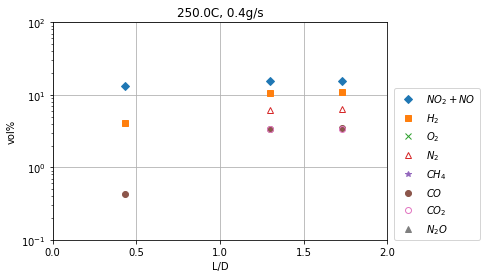

In [10]:
T_speeds  = np.array(np.meshgrid(temperature_c_options,injection_speed_options)).T.reshape(-1,2)

for i in range(len(T_speeds)):
    t = T_speeds[i,0]
    speed = T_speeds[i,1]
    plot_at_T_speed(t,speed)

In [11]:
gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [12]:
print(", ".join(gas.species_names))

Ne, NH3(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), O(36), Ar(37), HO2(39), H2O2(40), HOCO(41), CH2(42), CH2(S)(43), CH(44), CH2OH(45), CH3O(46), HCOH(47), CH3OO(48), CH2CO(49), C2H3(50), C(51), C2H2(52), C2H(53), CH3OOH(54), CH2OOH(55), HOCH2O(56), HOCHO(57), C2H5O(58), C2H5O2(59), C2H5O2(60), cC2H4O(61), CH2CHO(62), H2CC(63), CH3CO(64), C2H4O(65), C2H5O(66), C2H3O2(67), CHCHO(68), OCHCHO(69), HCCO(70), HCCOH(71), CHCHOH(72), C2(73), C2O(74), C2H6O(75), C2H5O(76), C2H5O3(77), cC2H3O(78), C2H3O3(79), OCHCO(80), C2H6O2(81), C2H5O2(82), C2H4O2(83), OCHO(84), NH2(85), NH(86), HNO(87), H2NO(88), HON(89), N(90), NNH(91), HONO(92), HNOH(93), HNO2(94), NO3(95), N2H2(96), H2N2(97), N2H3(98), N2H4(99), HCN(100), CN(101), HNC(102), NCO(103), HOCN(104), HNCO(105), NCCN(106), HNCN(107), NCN(108), HNCNH(109), HCNO(110), CH3CN(111), CH2C

In [13]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(201), H3NX(202), H2NOX(203), H2NOX(204), H3NOX(205), NO2X(206), NO3X(207), HNO3X(208), CH3OX(209), CH3OX(210), CH4OX(211), OX(213), NOX(215), NO2X(216), NOJX(217), H2X(219), SX(494), SX(495), CHO2X(506), HNO2X(513), HNX(532), HNOX(533), NX(604), SX(605), SX(606), SX(609), H2N2X(614), N2O3X(618), SX(623), HNOX(631), H2NOX(633), HNO2X(741), SX(759), HONOX(934), SX(1000), SX(1039), SX(1043), SX(1047), SX(1048), SX(1050), SX(1063), SX(1064), HNOX(1071), SX(1163), SX(1249), N2OX(1419), CNOX(1438), SX(1527), SX(1895), SX(2232), SX(2233), SX(2465), SX(3049), SX(3050), SX(3248), SX(3939), SX(4539), SX(4540), NO3X(4718), SX(4793), SX(4794), SX(4937), SX(5513), SX(5810), SX(5814), SX(6977), SX(7604), SX(9643)


In [14]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [15]:
# data_dict[(temp,ld,speed)] = data

graph1 = data_dict[(150,.430448223,0.2)]
graph1['N2(7)'].tail(1)

2000    0.078745
Name: N2(7), dtype: float64

In [16]:
#######################################################################
# Input Parameters for combustor
#######################################################################
# mass_flow_rate =  0.5e-3 # kg/s
mass_flow_rate = injection_speed_options[0]*1e-3

pressure = ct.one_atm # constant

ld = L_D_options[0]
length = 1.8*cm*ld  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

In [17]:
NReactors = 2001
def xlabels():
    ticks = []
    labels = []
    mm = 0
    while mm < length*1000:
        ticks.append( int(NReactors * mm * 0.001 / length ) )
        labels.append( str(mm) )
        mm += 1
    labels[-1] = labels[-1] + ' mm'
    plt.xticks(ticks, labels)
    plt.xlabel("Distance down reactor")

In [18]:
data = next(iter(data_dict.values()))
specs = list(data.columns)
specs = specs[4:-3]
excluded = [s for s in data.columns if s not in specs]
gas_species = [s for s in specs if 'X' not in s ]
adsorbates = [s for s in specs if 'X' in s]

In [19]:
def f(temperature_c, ld, speed):
    
#     print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
    print(f"Initial temperature {temperature_c :.1f} ºC")
#     print(f"Solver RTol {rtol :.1e}")
#     print(f"Solver ATol {atol :.1e}")
    print(f"L/D {ld :.2f}")
    print(f"injection speed {speed :.2f}")
    setting_tuple = (temperature_c, ld, speed)
    print(f"Simulation number {setting_dict[setting_tuple]}")
    data = data_dict[setting_tuple]
    
    length = 1.8*cm *ld #diam = 18mm, L = L/D * D mm
    data['T (C)'].plot()
    plt.ylabel('T (C)')
    xlabels()
    plt.show()
    
    data[['gas_heat','surface_heat']].plot()
    xlabels()
    #plt.savefig('gas_and_surface_heat.pdf')
    plt.show()

    species_to_plot = ['NH3(2)',
 'NH2OH(3)',
 'HNO3(4)',
 'CH3OH(5)',
 'H2O(6)',
 'N2(7)',
 'O2(8)',
 'NO2(9)',
 'NO(10)',
 'N2O(11)',
        ]
    data[species_to_plot].plot(title='gas mole fraction', logy=False)
    xlabels()
    plt.tight_layout()
    #plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    
    main_adsorbates = data[adsorbates].max().sort_values(ascending=False)[:10].keys()
    data[main_adsorbates].plot.area()
    xlabels()
    plt.xlim(0,len(data)+5)
    plt.tight_layout()
    plt.savefig(f'surface_coverages_top10.pdf')
    plt.show()

    return data
    

temp_ = widgets.SelectionSlider(
    options=temperature_c_options,
    value=temperature_c_options[1],
    description='Initial temperature (C)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

ld_ = widgets.SelectionSlider(
    options=L_D_options,
    value=L_D_options[1],
    description='L/D',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

speed_ = widgets.SelectionSlider(
    options=injection_speed_options,
    value=injection_speed_options[1],
    description='injection speed',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)



interact(f, temperature_c=temp_, ld=ld_, speed=speed_)


interactive(children=(SelectionSlider(continuous_update=False, description='Initial temperature (C)', index=1,…

<function __main__.f(temperature_c, ld, speed)>

In [20]:
data['Distance (mm)'].max()
# gas_species

7.748068014000001

In [21]:
# no2 = []
# no = []
# h2 = []
# o2 = []
# n2 = []
# ch4 = []
# co = []
# co2 = []
# n2o = []

# for l in range(len(L_D_options)):
#     no2.append(fracs[l][0][0])
#     no.append(fracs[l][0][1])
#     h2.append(fracs[l][0][2])
#     o2.append(fracs[l][0][3])
#     n2.append(fracs[l][0][4])
#     ch4.append(fracs[l][0][5])
#     co.append(fracs[l][0][6])
#     co2.append(fracs[l][0][7])
#     n2o.append(fracs[l][0][8])
    
# no2_no = np.array(no2) + np.array(no)
# no2_no *=100
# h2 = np.array(h2)*100
# o2 = np.array(o2)*100
# n2 = np.array(n2)*100
# ch4 = np.array(ch4)*100
# co = np.array(co)*100
# co2 = np.array(co2)*100
# n2o = np.array(n2o)*100

# plt.plot(L_D_options,no2_no,'D', label = '$NO_2+NO$')
# plt.plot(L_D_options,h2,'s', label = '$H_2$')
# plt.plot(L_D_options,o2,'x', label = '$O_2$')
# plt.plot(L_D_options,n2,'^',markerfacecolor='none', label = '$N_2$')
# plt.plot(L_D_options,ch4,'*', label = '$CH_4$')
# plt.plot(L_D_options,co,'o', label = '$CO$')
# plt.plot(L_D_options,co2,'o',markerfacecolor='none', label = '$CO_2$')
# plt.plot(L_D_options,n2o,'^', label = '$N_2O$')
# plt.yscale("log")
# plt.xlim(0, 2)
# plt.ylim(0.1,100)
# plt.xticks(ticks=[0,.5,1,1.5,2])
# plt.yticks(ticks=[0.1,1,10,100])
# plt.title('{:}C, {:.1f}g/s'.format(t,speed))
# plt.legend(loc=(1.02,0))
# plt.xlabel('L/D')
# plt.ylabel('vol%')
# plt.grid()
# plt.show()

In [22]:
cat_area_per_vol=2.80e+05

In [23]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
1792 : C2H4N(160) + O(36) => CH3(18) + H(20) + NCO(103)         0
895 : C2H5O(66) + O2(8) <=> C2H4O(65) + HO2(39)                0
589 : S(665) + S(674) <=> S(665) + S(7627)                     0
590 : S(2447) <=> 2 S(1489)                                    0
591 : NH2(85) + S(2056) <=> S(2447)                            0
592 : C2H4(200) <=> C2H4(25)                                   0
593 : C2H4(200) <=> C2H4(25)                                   0

Highest net rates of progress, surface
820 : SX(9643) + X(1) <=> HNO2X(513) + SX(7604)                0
268 : H2NOX(204) + HNOX(1071) <=> HNX(532) + SX(759)           0
278 : H3NOX(205) + HNOX(1071) <=> H2NX(201) + SX(759)          0
277 : H3NOX(205) + HNOX(1071) <=> H2NOX(203) + H2NOX(633)         0
276 : H2OX(30) + HNOX(1071) <=> HX(26) + SX(759)               0
275 : H2OX(30) + HNOX(1071) <=> H2NOX(633) + HOX(29)           0
274 : HNOX(1071) + X(1) <=> HX(26) + NOX(215)                  0

Highest f

In [24]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
296 : CH2OH(45) + NO(10) <=> S(1494)                     6.0e+24
295 : CH2OH(45) + H2NO(88) <=> S(1108)                   6.0e+24
382 : HCO(22) + NO(10) <=> CHNO2(397)                    6.0e+24
437 : CH2OH(45) + HNOH(93) <=> ONCO(1021)                6.0e+24
241 : CH2OH(45) + NO2(9) <=> S(1216)                     6.0e+24
596 : HCO(22) + NO2(9) <=> CHNO3(372)                    6.0e+24
474 : HCO(22) + HNOH(93) <=> ONCDO(266)                  6.0e+24

Highest forward rate constants, surface
 94 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 83 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
467 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
745 : SX(1043) + X(1) <=> HX(26) + SX(1050)              3.7e+20
141 : SX(1039) + X(1) <=> HX(26) + SX(1047)              3.7e+20
428 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18
 15 : HX(26) + OX(27) <=> HOX(29) + X(1)                 1.4e+18

Highest rev

In [25]:
sim.time

NameError: name 'sim' is not defined

In [ ]:
gas.TDY = TDY
r.syncState()
r.thermo.T

In [ ]:
r.thermo.X - gas.X

In [ ]:
report_rate_constants()

In [ ]:
def xlabels():
    plt.xticks([0,NReactors/4,NReactors/2,3*NReactors/4, NReactors],['0','','','',f'{length*1000:.0f} mm'])
    plt.xlabel("Distance down reactor")

In [ ]:
data['T (C)'].plot()
plt.ylabel('T (C)')
xlabels()

In [ ]:
data[['NH2OH(3)', 'HNO3(4)', 'CH3OH(5)']].plot()
plt.ylabel('Mole fraction')
xlabels()

In [ ]:
list(data.columns)[:4]

In [ ]:
data[['T (C)', 'alpha']].plot()
xlabels()

In [ ]:
ax1 = data['T (C)'].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-2, 2)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [ ]:
data.columns

In [ ]:
data[['gas_heat','surface_heat']].plot()
#plt.ylim(-1e7, 1e7)
xlabels()
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


In [ ]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
xlabels()
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('heats-and-alpha.pdf')
plt.show()

In [ ]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

In [ ]:
data[['alpha']].plot(logy=True)
xlabels()

In [ ]:
data.plot(x='T (C)',y='alpha')


In [ ]:
specs = list(data.columns)
specs = specs[4:-1]

gas_species = [s for s in specs if 'X' not in s]
adsorbates = [s for s in specs if 'X' in s]

gas_species, adsorbates

In [ ]:
data[gas_species[0:5]].plot(logy=True, logx=True)

In [ ]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='gas mole fraction', logy=False)
    xlabels()
    plt.tight_layout()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='surface coverages', logy=False)
    xlabels()
    plt.tight_layout()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()